In [1]:
import sys
import sql
import pandas as pd
from functools import reduce
from tabulate import tabulate
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
q='''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, count(distinct sha) as commit_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join change_commit cc on ri.id = cc.release_info_id
    where rc.commit is not null
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
cc = pd.DataFrame(sql.execute(q)) 

In [81]:
q= '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id,
       count(distinct filename) as file_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where fe.source = 1) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
cf = pd.DataFrame(sql.execute(q))

In [83]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id, 
       sum(lines_added + lines_removed) as loc_change
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join (select scf.* from change_file scf
    join file_extensions fe on scf.format = fe.id
    where fe.source = 1) as cf on ri.id = cf.release_info_id
    where rc.commit is not null
    group by advisory_id, p.ecosystem, a.package_id, ri.id;'''
loc = pd.DataFrame(sql.execute(q))

In [84]:
q = '''select advisory_id, p.ecosystem, a.package_id, ri.id as release_id,
       count(distinct author_mail) as contributor_count
    from advisory a
    join package p on a.package_id = p.id
    join fixing_releases fr on a.id = fr.advisory_id
    join release_info ri on
        fr.version = ri.version and ri.package_id = a.package_id
    join release_commit rc on p.id = rc.package_id and rc.version = fr.version
    left join change_commit cc on ri.id = cc.release_info_id
    where rc.commit is not null
    group by advisory_id, p.ecosystem, a.package_id, ri.id'''
contrib = pd.DataFrame(sql.execute(q))

In [85]:
cc['release_id'].nunique(), cf['release_id'].nunique(), loc['release_id'].nunique(), contrib['release_id'].nunique()

(3513, 3513, 3513, 3513)

In [86]:
df = reduce(lambda x, y: pd.merge(x,y, on =['advisory_id','ecosystem', 'package_id', 'release_id']), [cc,cf,loc,contrib])
df['loc_change'] = df['loc_change'].apply(lambda x: 0 if x is None else x)
df['loc_change'] = df['loc_change'].astype(int)

In [87]:
total = ['Total', df['advisory_id'].nunique(), df['package_id'].nunique(), df['release_id'].nunique(),
        df['commit_count'].median(), df['file_count'].median(), df['loc_change'].median(), df['contributor_count'].median()]
total

['Total', 3231, 1554, 3513, 14.0, 18.0, 498.0, 4.0]

In [88]:
q = ''' select ecosystem, count(distinct ri.id) as patch
from advisory a
join package p on a.package_id = p.id
join fixing_releases fr on a.id = fr.advisory_id
join release_info ri on
    fr.version = ri.version and ri.package_id = a.package_id
join release_commit rc on p.id = rc.package_id and rc.version = fr.version
join release_type rt on ri.id = rt.release_info_id
where rc.commit is not null and rt.type ='patch'
group by ecosystem;'''
patch = pd.DataFrame(sql.execute(q))
total.append(patch['patch'].sum())
total

['Total', 3231, 1554, 3513, 14.0, 18.0, 498.0, 4.0, 2421]

In [89]:
adv = df.groupby('ecosystem')[['advisory_id']].nunique()
pkg = df.groupby('ecosystem')[['package_id']].nunique()
rel = df.groupby('ecosystem')[['release_id']].nunique()
commits =df.groupby('ecosystem')[['commit_count']].median()
files = df.groupby('ecosystem')[['file_count']].median()
loc_change = df.groupby('ecosystem')[['loc_change']].median()
contributors = df.groupby('ecosystem')[['contributor_count']].median()
final =reduce(lambda x,y : pd.merge(x,y,on='ecosystem'),[adv, pkg, rel, commits, files, loc_change, contributors, patch])
final['temp'] = round(final['patch'] / final['release_id'] * 100 , 1)
final['patch'] = final['patch'].map(str) +' (' + final['temp'].map(str) +'%)'
total[-1] = str(total[-1]) + ' (' + str(round(total[-1] / total[3] * 100, 1)) +'%)'
final['temp'] = final['ecosystem'].str.lower()
final = final.sort_values(by = 'temp', ascending=True)
final = final.drop('temp', axis=1)
final.loc[len(final)] = total
final

,ecosystem,advisory_id,package_id,release_id,commit_count,file_count,loc_change,contributor_count,patch
0,Composer,748,203,827,12.0,23.0,522.5,4.0,706 (85.4%)
1,Go,206,164,266,18.5,32.0,1339.0,7.0,191 (71.8%)
2,Maven,757,391,913,33.0,41.0,1567.5,5.0,514 (56.3%)
5,npm,614,409,647,6.0,6.0,166.0,2.0,410 (63.4%)
3,NuGet,237,60,153,12.0,20.0,498.0,7.0,128 (83.7%)
6,pip,471,220,435,18.5,12.0,270.5,5.0,276 (63.4%)
4,RubyGems,198,107,272,6.0,10.0,90.5,2.0,196 (72.1%)
7,Total,3231,1554,3513,14.0,18.0,498.0,4.0,2421 (68.9%)


In [90]:
print(tabulate(final, tablefmt='latex', headers='keys',showindex=False))

\begin{tabular}{lrrrrrrrl}
\hline
 ecosystem   &   advisory\_id &   package\_id &   release\_id &   commit\_count &   file\_count &   loc\_change &   contributor\_count & patch        \\
\hline
 Composer    &           748 &          203 &          827 &           12   &           23 &        522.5 &                   4 & 706 (85.4\%)  \\
 Go          &           206 &          164 &          266 &           18.5 &           32 &       1339   &                   7 & 191 (71.8\%)  \\
 Maven       &           757 &          391 &          913 &           33   &           41 &       1567.5 &                   5 & 514 (56.3\%)  \\
 npm         &           614 &          409 &          647 &            6   &            6 &        166   &                   2 & 410 (63.4\%)  \\
 NuGet       &           237 &           60 &          153 &           12   &           20 &        498   &                   7 & 128 (83.7\%)  \\
 pip         &           471 &          220 &          435 &           

In [91]:
df['commit_count'].quantile(.93)

236.6300000000001

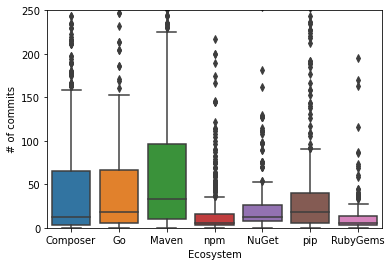

In [98]:
ax = sns.boxplot(y='commit_count', x='ecosystem', data = df, order =['Composer','Go','Maven','npm','NuGet','pip','RubyGems'])
ax.set(ylim=(0,250), xlabel='Ecosystem', ylabel='# of commits')
plt.savefig('commit_complexity.png',bbox_inches='tight')